
VALIDATION
Accuracy : 0.8173076923076923
Precision: 0.8229166666666666
Recall   : 0.9753086419753086
F1       : 0.8926553672316384
Confusion matrix:
 [[ 6 17]
 [ 2 79]]

TEST
Accuracy : 0.7238095238095238
Precision: 0.797752808988764
Recall   : 0.8658536585365854
F1       : 0.8304093567251462
Confusion matrix:
 [[ 5 18]
 [11 71]]


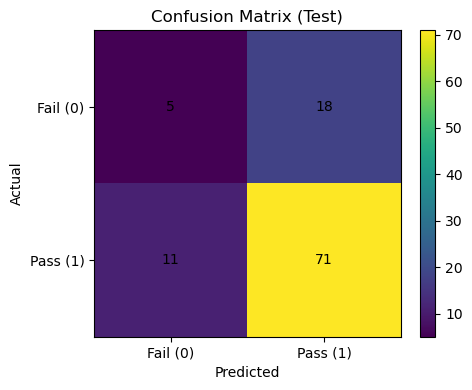

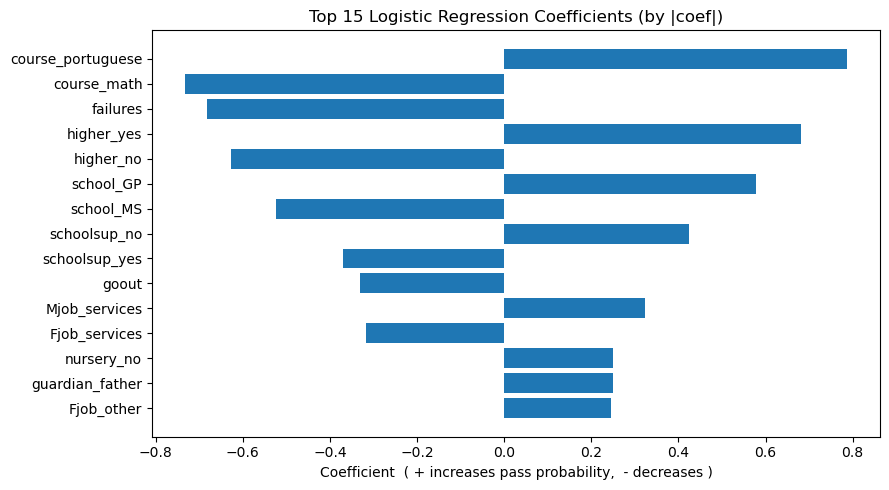


Top 15 features:
course_portuguese                    +0.7869
course_math                          -0.7322
failures                             -0.6830
higher_yes                           +0.6821
higher_no                            -0.6275
school_GP                            +0.5780
school_MS                            -0.5234
schoolsup_no                         +0.4238
schoolsup_yes                        -0.3692
goout                                -0.3301
Mjob_services                        +0.3236
Fjob_services                        -0.3165
nursery_no                           +0.2508
guardian_father                      +0.2500
Fjob_other                           +0.2457


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

mat = pd.read_csv("student-mat.csv", sep=";")
por = pd.read_csv("student-por.csv", sep=";")

mat["course"] = "math"
por["course"] = "portuguese"

df = pd.concat([mat, por], ignore_index=True)

df["pass"] = (df["G3"] >= 10).astype(int)

# Drop grades to avoid leakage
X = df.drop(columns=["G1", "G2", "G3", "pass"])
y = df["pass"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("lr", LogisticRegression(max_iter=5000))
])

clf.fit(X_train, y_train)

def evaluate(name, X_split, y_true):
    y_pred = clf.predict(X_split)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
    print("F1       :", f1_score(y_true, y_pred, zero_division=0))
    print("Confusion matrix:\n", cm)

    return y_pred, cm

val_pred, _ = evaluate("VALIDATION", X_val, y_val)
test_pred, test_cm = evaluate("TEST", X_test, y_test)

plt.figure(figsize=(5,4))
plt.imshow(test_cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
plt.xticks([0, 1], ["Fail (0)", "Pass (1)"])
plt.yticks([0, 1], ["Fail (0)", "Pass (1)"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(test_cm[i, j]), ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

ohe = clf.named_steps["prep"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols.to_numpy(), cat_names])

coefs = clf.named_steps["lr"].coef_[0]

top_k = 15
top_idx = np.argsort(np.abs(coefs))[::-1][:top_k]

top_features = feature_names[top_idx]
top_coefs = coefs[top_idx]

plt.figure(figsize=(9,5))
plt.barh(top_features, top_coefs)
plt.gca().invert_yaxis()
plt.title("Top 15 Logistic Regression Coefficients (by |coef|)")
plt.xlabel("Coefficient  ( + increases pass probability,  - decreases )")
plt.tight_layout()
plt.show()

print("\nTop 15 features:")
for f, c in zip(top_features, top_coefs):
    print(f"{f:35s}  {c:+.4f}")

shape: (1044, 30)
pass rate: 0.7796934865900383
train: (835, 30) val: (104, 30) test: (105, 30)

starting gridsearch: 40 param combos x 10 folds = 400 fits


gridsearch fits:   0%|          | 0/400 [00:00<?, ?it/s]


best params: {'lr__C': 0.01, 'lr__l1_ratio': 0.1}
best cv balanced acc: 0.6965666789350999

getting out-of-fold probs for threshold (this part can take a bit)...

threshold picked from OOF train preds: 0.55
OOF train balanced acc at that threshold: 0.7048

VALIDATION (OOF threshold)
threshold: 0.55
accuracy: 0.7019
balanced acc: 0.653
precision (pass): 0.8571
recall (pass):    0.7407
f1 (pass):        0.7947
recall (fail):    0.5652
confusion matrix:
 [[13 10]
 [21 60]]

TEST (OOF threshold)
threshold: 0.55
accuracy: 0.6857
balanced acc: 0.6267
precision (pass): 0.8451
recall (pass):    0.7317
f1 (pass):        0.7843
recall (fail):    0.5217
confusion matrix:
 [[12 11]
 [22 60]]


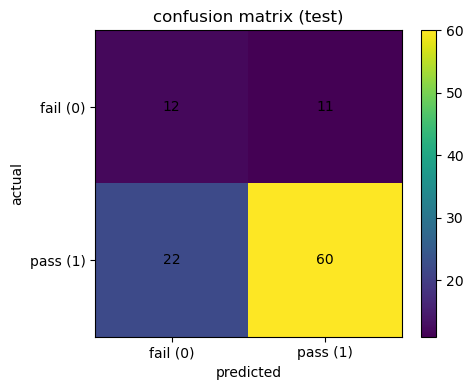


non-zero features kept: 162 out of 1596

top features (by |coef|):
failures paid_no                                         -0.1453
failures schoolsup_no                                    -0.1448
paid_no higher_yes                                       +0.1155
schoolsup_no higher_yes                                  +0.1071
goout romantic_no                                        -0.1005
failures absences                                        +0.0922
school_GP paid_no                                        +0.0834
famrel Dalc                                              -0.0789
failures nursery_yes                                     -0.0746
failures guardian_father                                 -0.0701
failures romantic_yes                                    -0.0695
failures                                                 -0.0662
failures Fjob_services                                   -0.0661
famrel romantic_no                                       +0.0629
failures internet_yes 

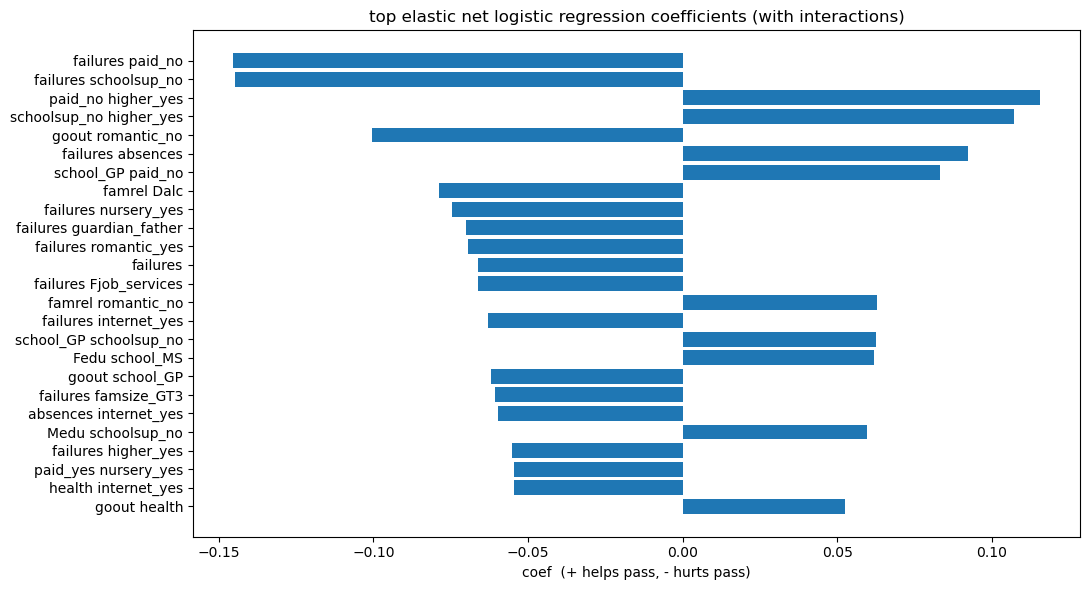

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, balanced_accuracy_score
)

# progress bar stuff
from tqdm.auto import tqdm
import joblib


class TqdmJoblib(joblib.parallel.BatchCompletionCallBack):
    def __init__(self, *args, **kwargs):
        self.pbar = kwargs.pop("pbar")
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        self.pbar.update(n=self.batch_size)
        return super().__call__(*args, **kwargs)


# ----------------------------
#  load + combine
# ----------------------------
df_mat = pd.read_csv("student-mat.csv", sep=";")
df_por = pd.read_csv("student-por.csv", sep=";")
df = pd.concat([df_mat, df_por], ignore_index=True)

# ----------------------------
# label (pass/fail)
# ----------------------------
df["pass"] = (df["G3"] >= 10).astype(int)

X = df.drop(columns=["G1", "G2", "G3", "pass"])
y = df["pass"]

print("shape:", X.shape, flush=True)
print("pass rate:", y.mean(), flush=True)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape, flush=True)

cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

prep = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

pipe = Pipeline([
    ("prep", prep),
    ("interactions", PolynomialFeatures(
        degree=2,
        interaction_only=True,
        include_bias=False
    )),
    ("lr", LogisticRegression(
        penalty="elasticnet",
        solver="saga",            # required for elastic net
        class_weight="balanced",
        max_iter=30000,
        n_jobs=-1
    ))
])

# ----------------------------
# 7) tune C + l1_ratio w/ 10-fold CV 
# ----------------------------
param_grid = {
    "lr__C": [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5],
    "lr__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=cv10,
    n_jobs=-1,
    refit=True
)

n_candidates = len(param_grid["lr__C"]) * len(param_grid["lr__l1_ratio"])
n_fits = n_candidates * cv10.get_n_splits()

print(f"\nstarting gridsearch: {n_candidates} param combos x {cv10.get_n_splits()} folds = {n_fits} fits", flush=True)

with tqdm(total=n_fits, desc="gridsearch fits", leave=True) as pbar:
    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = lambda *args, **kwargs: TqdmJoblib(*args, pbar=pbar, **kwargs)
    try:
        grid.fit(X_train, y_train)
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb

model = grid.best_estimator_

print("\nbest params:", grid.best_params_, flush=True)
print("best cv balanced acc:", grid.best_score_, flush=True)

def eval_it(tag, X_split, y_true, thr=0.5):
    probs = model.predict_proba(X_split)[:, 1]
    preds = (probs >= thr).astype(int)

    cm = confusion_matrix(y_true, preds)
    TN, FP = cm[0, 0], cm[0, 1]
    fail_recall = TN / (TN + FP) if (TN + FP) else 0.0

    print("\n" + tag)
    print("threshold:", round(thr, 3))
    print("accuracy:", round(accuracy_score(y_true, preds), 4))
    print("balanced acc:", round(balanced_accuracy_score(y_true, preds), 4))
    print("precision (pass):", round(precision_score(y_true, preds, zero_division=0), 4))
    print("recall (pass):   ", round(recall_score(y_true, preds, zero_division=0), 4))
    print("f1 (pass):       ", round(f1_score(y_true, preds, zero_division=0), 4))
    print("recall (fail):   ", round(fail_recall, 4))
    print("confusion matrix:\n", cm)

    return probs, preds, cm

# ----------------------------
# 9) choose threshold using OUT-OF-FOLD probs on train (stable)
# ----------------------------
print("\ngetting out-of-fold probs for threshold (this part can take a bit)...", flush=True)

oof_probs = cross_val_predict(
    model, X_train, y_train,
    cv=cv10,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

ths = np.linspace(0.1, 0.9, 81)

best_thr = 0.5
best_bal = -1

for t in ths:
    oof_pred = (oof_probs >= t).astype(int)
    bal = balanced_accuracy_score(y_train, oof_pred)
    if bal > best_bal:
        best_bal = bal
        best_thr = t

print("\nthreshold picked from OOF train preds:", round(best_thr, 3), flush=True)
print("OOF train balanced acc at that threshold:", round(best_bal, 4), flush=True)

# ----------------------------
# 10) final eval
# ----------------------------
_ = eval_it("VALIDATION (OOF threshold)", X_val, y_val, thr=best_thr)
test_probs, test_preds, test_cm = eval_it("TEST (OOF threshold)", X_test, y_test, thr=best_thr)

# ----------------------------
# 11) plot confusion matrix (test)
# ----------------------------
plt.figure(figsize=(5, 4))
plt.imshow(test_cm, interpolation="nearest")
plt.title("confusion matrix (test)")
plt.colorbar()
plt.xticks([0, 1], ["fail (0)", "pass (1)"])
plt.yticks([0, 1], ["fail (0)", "pass (1)"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(test_cm[i, j]), ha="center", va="center")

plt.xlabel("predicted")
plt.ylabel("actual")
plt.tight_layout()
plt.show()

# ----------------------------
# 12) print top non-zero coefficients (includes interactions)
# ----------------------------
prep_fitted = model.named_steps["prep"]
poly_fitted = model.named_steps["interactions"]
lr_fitted = model.named_steps["lr"]

ohe = prep_fitted.named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_cols)
base_feat_names = np.concatenate([num_cols.to_numpy(), cat_names])

poly_feat_names = poly_fitted.get_feature_names_out(base_feat_names)

coefs = lr_fitted.coef_[0]
nz = np.where(coefs != 0)[0]

print("\nnon-zero features kept:", len(nz), "out of", len(poly_feat_names), flush=True)

top_k = 25
top_idx = nz[np.argsort(np.abs(coefs[nz]))[::-1][:top_k]]

print("\ntop features (by |coef|):", flush=True)
for i in top_idx:
    print(f"{poly_feat_names[i]:55s}  {coefs[i]:+.4f}")

plt.figure(figsize=(11, 6))
plt.barh(poly_feat_names[top_idx][::-1], coefs[top_idx][::-1])
plt.title("top elastic net logistic regression coefficients (with interactions)")
plt.xlabel("coef  (+ helps pass, - hurts pass)")
plt.tight_layout()
plt.show()

In [5]:
mat = pd.read_csv("student-mat.csv", sep=";")
por = pd.read_csv("student-por.csv", sep=";")

mat["course"] = "math"
por["course"] = "portuguese"

df = pd.concat([mat, por], ignore_index=True)
df["pass"] = (df["G3"] >= 10).astype(int)

X = df.drop(columns=["G1", "G2", "G3", "pass"])
y = df["pass"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)
target_recall_fail = 0.80 

val_probs_pass = clf.predict_proba(X_val)[:, 1]


thresholds = np.linspace(0.01, 0.99, 99)

best_thr = None
best_score = -1

for thr in thresholds:
    val_pred = (val_probs_pass >= thr).astype(int)
    cm = confusion_matrix(y_val, val_pred, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()

    recall_fail = TN / (TN + FP) if (TN + FP) else 0.0

    if recall_fail >= target_recall_fail:
        score = balanced_accuracy_score(y_val, val_pred)
        if score > best_score:
            best_score = score
            best_thr = thr

if best_thr is None:
    best_thr = 0.5
    best_recall_fail = -1
    for thr in thresholds:
        val_pred = (val_probs_pass >= thr).astype(int)
        cm = confusion_matrix(y_val, val_pred, labels=[0, 1])
        TN, FP, FN, TP = cm.ravel()
        recall_fail = TN / (TN + FP) if (TN + FP) else 0.0
        if recall_fail > best_recall_fail:
            best_recall_fail = recall_fail
            best_thr = thr

print("Chosen threshold (from VAL):", round(best_thr, 3))
print("VAL best balanced acc (subject to recall_fail target):", round(best_score, 4) if best_score != -1 else "N/A")

def report_split(tag, X_split, y_true, thr):
    probs_pass = clf.predict_proba(X_split)[:, 1]
    pred = (probs_pass >= thr).astype(int)

    cm = confusion_matrix(y_true, pred, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()

    recall_fail = TN / (TN + FP) if (TN + FP) else 0.0  
    recall_pass = TP / (TP + FN) if (TP + FN) else 0.0 

    print("\n" + tag)
    print("thr:", round(thr, 3))
    print("accuracy:", round(accuracy_score(y_true, pred), 4))
    print("balanced acc:", round(balanced_accuracy_score(y_true, pred), 4))
    print("precision (pass=1):", round(precision_score(y_true, pred, zero_division=0), 4))
    print("recall (pass=1):   ", round(recall_pass, 4))
    print("recall (fail=0):   ", round(recall_fail, 4))
    print("f1 (pass=1):       ", round(f1_score(y_true, pred, zero_division=0), 4))
    print("confusion matrix [ [TN FP], [FN TP] ]:\n", cm)

report_split("VALIDATION (chosen thr)", X_val, y_val, best_thr)
report_split("TEST (chosen thr)", X_test, y_test, best_thr)

Chosen threshold (from VAL): 0.84
VAL best balanced acc (subject to recall_fail target): 0.7496

VALIDATION (chosen thr)
thr: 0.84
accuracy: 0.6827
balanced acc: 0.7496
precision (pass=1): 0.9444
recall (pass=1):    0.6296
recall (fail=0):    0.8696
f1 (pass=1):        0.7556
confusion matrix [ [TN FP], [FN TP] ]:
 [[20  3]
 [30 51]]

TEST (chosen thr)
thr: 0.84
accuracy: 0.6095
balanced acc: 0.6249
precision (pass=1): 0.8596
recall (pass=1):    0.5976
recall (fail=0):    0.6522
f1 (pass=1):        0.705
confusion matrix [ [TN FP], [FN TP] ]:
 [[15  8]
 [33 49]]


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

def pick_threshold_for_fail_recall(est, X_split, y_true, target=0.80):
    probs = est.predict_proba(X_split)[:, 1]  # P(pass)
    ths = np.linspace(0.01, 0.99, 199)
    rows = []

    for t in ths:
        pred = (probs >= t).astype(int)
        cm = confusion_matrix(y_true, pred, labels=[0,1])
        TN, FP, FN, TP = cm.ravel()

        recall_fail = TN/(TN+FP) if (TN+FP) else 0.0
        recall_pass = TP/(TP+FN) if (TP+FN) else 0.0
        bal = (recall_fail + recall_pass)/2

        if recall_fail >= target:
            rows.append((t, recall_fail, recall_pass, bal, TN, FP, FN, TP))

    if not rows:
        return None, None

    df = pd.DataFrame(rows, columns=["thr","recall_fail","recall_pass","balanced_acc","TN","FP","FN","TP"])
    best = df.sort_values("balanced_acc", ascending=False).iloc[0]
    return best, df.sort_values("balanced_acc", ascending=False).head(10)

best, top10 = pick_threshold_for_fail_recall(model, X_val, y_val, target=0.80)  # or clf
print(best)
print("\nTop 10 thresholds meeting target:\n", top10)

thr              0.747475
recall_fail      0.956522
recall_pass      0.209877
balanced_acc     0.583199
TN              22.000000
FP               1.000000
FN              64.000000
TP              17.000000
Name: 6, dtype: float64

Top 10 thresholds meeting target:
          thr  recall_fail  recall_pass  balanced_acc  TN  FP  FN  TP
6   0.747475     0.956522     0.209877      0.583199  22   1  64  17
5   0.742525     0.913043     0.222222      0.567633  21   2  63  18
7   0.752424     0.956522     0.172840      0.564681  22   1  67  14
0   0.717778     0.826087     0.296296      0.561192  19   4  57  24
8   0.757374     0.956522     0.160494      0.558508  22   1  68  13
2   0.727677     0.826087     0.283951      0.555019  19   4  58  23
1   0.722727     0.826087     0.283951      0.555019  19   4  58  23
13  0.782121     1.000000     0.098765      0.549383  23   0  73   8
14  0.787071     1.000000     0.098765      0.549383  23   0  73   8
3   0.732626     0.826087     0.259259    